# Reverse image search
In this example we will be going over the code required to perform similarity searches on images. This example uses a ResNet model to extract image features that are then used with Milvus to build a system that can perform the searches. 
## Data

We use the PASCAL VOC image set, which contains 17125 images within 20 categories: human, animals, transportation, etc.

Dataset size: ~ 2 GB.

Directory Structure:  
The file loader used in this requires that the folders containing the images are subfolders. 

```bash
__data_directory  
    |__sub_folder_1  
    |   |__image1.jpg  
    |   |__image2.jpg  
    |__sub_folder_2  
        |__imageX.jpg  
```

> Note: You can also use other images for testing. This example only requires that the images are PIL compatible.

## Requirements

|  Packages |  Servers |
| --------------- | -------------- |
| pymilvus        | milvus-2.0   |
| redis           | redis          |
| torch |
| torchvision |
| matplotlib |
| pillow |
| numpy |
| gdown |

We have included a requirements.txt file in order to easily satisfy the required packages. 

## Up and Running

### Installing Packages
Install the required python packages with `requirements.txt`.

In [1]:
! pip install -r requirements.txt

  Using cached pymilvus_orm-2.0.0rc1-py3-none-any.whl (35 kB)
  Using cached redis-3.5.3-py2.py3-none-any.whl (72 kB)
     |████████████████████████████████| 127.9 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 13.9 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 7.2 MB 1.0 MB/s eta 0:00:01
  Using cached Pillow-8.3.1-cp38-cp38-macosx_10_10_x86_64.whl (2.9 MB)
     |████████████████████████████████| 16.9 MB 3.0 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pandas-1.2.4-cp38-cp38-macosx_10_9_x86_64.whl (10.5 MB)
  Using cached pymilvus-2.0.0rc1-py3-none-any.whl (70 kB)
  Using cached pytz-2021.1-py2.py3-none-any.whl (510 kB)
  Using cached grpcio-1.37.1-cp38-cp38-macosx_10_10_x86_64.whl (3.9 MB)
  Using cached grpcio_tools-1.37.1-cp38-cp38-macosx_10_10_x86_64.whl (2.0 MB)
  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Using cache

## Starting Milvus Server

This demo uses Milvus 2.0-rc5, please refer to the [Install Milvus](https://milvus.io/docs/v2.0.0/install_standalone-docker.md) guide to learn how to use this docker container. For this example we wont be mapping any local volumes. 

### Starting Redis Server
We are using Redis as a metadata storage service. Code can easily be modified to use a python dictionary, but that usually does not work in any use case outside of quick examples. We need a metadata storage service in order to be able to be able to map between embeddings and their corresponding images. 

In [1]:
!docker run  --name redis -d -p 6379:6379 redis

docker: Error response from daemon: Conflict. The container name "/redis" is already in use by container "8ae9ff730522f58ba1090c0252996c882abdcfe8f8d747c77f23168034931c1e". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


### Downloading Data
If the download does not work it is most likely because the website is down. An alternative download link can be found [here](https://drive.google.com/file/d/1jdudBiUu41kL-U5lhH3ari_WBRXyedWo/view?usp=sharing). Once downloaded, unzip and place it in the working directory.

There are two options for the data download, the original [VOCtraining data](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar) and a reduced sized file found [here](https://drive.google.com/file/d/1jdudBiUu41kL-U5lhH3ari_WBRXyedWo/view?usp=sharing)

In [7]:
# Reduced File Download
# ! gdown "https://drive.google.com/u/1/uc?id=1jdudBiUu41kL-U5lhH3ari_WBRXyedWo&export=download"
# ! unzip -q VOCdevkit.zip
# ! rm VOCdevkit.zip

Downloading...
From: https://drive.google.com/u/1/uc?id=1jdudBiUu41kL-U5lhH3ari_WBRXyedWo&export=download
To: E:\Documents\ComputerScience\Information Retrieval\milvus\bootcamp-solutions-reverse_image_search\VOCdevkit.zip

  0%|          | 0.00/511M [00:00<?, ?B/s]
  0%|          | 524k/511M [00:01<24:36, 346kB/s]
  0%|          | 1.05M/511M [00:03<27:27, 310kB/s]
  0%|          | 1.57M/511M [00:04<24:56, 341kB/s]
  0%|          | 2.10M/511M [00:05<20:28, 414kB/s]
  1%|          | 2.62M/511M [00:06<16:43, 507kB/s]
  1%|          | 3.15M/511M [00:06<13:17, 638kB/s]
  1%|          | 3.67M/511M [00:06<10:50, 781kB/s]
  1%|          | 4.19M/511M [00:07<09:12, 918kB/s]
  1%|          | 4.72M/511M [00:07<08:02, 1.05MB/s]
  1%|1         | 5.24M/511M [00:07<07:16, 1.16MB/s]
  1%|1         | 5.77M/511M [00:08<06:45, 1.25MB/s]
  1%|1         | 6.29M/511M [00:08<06:23, 1.32MB/s]
  1%|1         | 6.82M/511M [00:09<06:09, 1.37MB/s]
  1%|1         | 7.34M/511M [00:09<05:59, 1.40MB/s]
  2%|1         

'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Original File (uncomment and run)
# ! wget -O 'file1.tar' 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar' -q --show-progress
# ! tar -xf 'file1.tar'
# ! rm -r -f ./VOCdevkit/VOC2012/Annotations
# ! rm -r -f ./VOCdevkit/VOC2012/ImageSets
# ! rm -r -f ./VOCdevkit/VOC2012/Annotations
# ! rm -r -f ./VOCdevkit/VOC2012/SegmentationClass
# ! rm -r -f ./VOCdevkit/VOC2012/SegmentationObject
# ! rm -f 'file1.tar'

## Code Overview

### Connecting to Servers

We first start off by connecting to the servers. In this case the docker containers are running on localhost and the ports are the default ports. 

In [2]:
#Connectings to Milvus and Redis

import redis
from pymilvus import *

connections.connect(host="127.0.0.1", port=19530)
red = redis.Redis(host = '127.0.0.1', port=6379, db=0)
red.flushdb()

ModuleNotFoundError: No module named 'redis'

### Building Collection and Setting Index

The next step involves creating a collection. A collection in Milvus is similar to a table in a relational database, and is used for storing all the vectors. To create a collection, we first must select a name and the dimension of the vectors being stored within.

In [14]:
#Creat a collection

collection_name = "image_similarity_search"
dim = 512
default_fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=dim)
]
default_schema = CollectionSchema(fields=default_fields, description="Image test collection")

collection = Collection(name=collection_name, schema=default_schema)

After creating the collection we want to assign it an index type. This can be done before or after inserting the data. When done before, indexes will be made as data comes in and fills the data segments. In this example we are using IVF_SQ8 which requires the **nlist** parameter. Each index types carries its own parameters. More info about this param can be found [here](https://milvus.io/docs/v2.0.0/index.md#CPU).

In [15]:
# Create IVF_SQ8 index to the  collection
default_index = {"index_type": "IVF_SQ8", "params": {"nlist": 2048}, "metric_type": "L2"}
collection.create_index(field_name="vector", index_params=default_index)
collection.load()

### Processing and Storing Images

In order to store the images in Milvus, we must first run them through the ResNet model. In this case, we are using the pretrained ResNet-18 model provided by PyTorch. In order to get the feature vectors, we must remove the classifying layer that comes at the end. 

In [16]:
# Preparing model and dataloader

import torch
from torchvision import datasets, transforms, models
try:
    model = models.resnet18(pretrained=True)
except(HTTPError):
    time.sleep(60)

encoder = torch.nn.Sequential(*(list(model.children())[:-1]))
encoder.eval()

data_dir = "./VOCdevkit"

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\strai/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In this example we are also using a slightly modified dataloader that also returns the file path of the image. With this dataloader we are also transforming the images into what ResNet model takes as input. 

In [17]:
#Dataset and Loader

class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        return super(ImageFolderWithPaths, self).__getitem__(index) + (self.imgs[index][0],)

dataset = ImageFolderWithPaths(data_dir, transform=transforms.Compose([
                                                transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))

dataloader = torch.utils.data.DataLoader(dataset, num_workers=0, batch_size = 256)

Inputting the data involves three major steps. First, the images need to be run through the model. This outputs vectors for each image. Second, these vectors are pushed into Milvus. Milvus then returns the corresponding IDs for the vectors. Third, these IDs and the image filepaths are used as the key and value for storage in Redis. Redis is used so that we can return the original image as a result. 

In [18]:
# Processing and storing

steps = len(dataloader)
step = 0
for inputs, labels, paths in dataloader:
    with torch.no_grad():
        output = encoder(inputs).squeeze()
        output = output.numpy()

    mr = collection.insert([output.tolist()])
    ids = mr.primary_keys
    for x in range(len(ids)):
        red.set(str(ids[x]), paths[x])
    if step%5 == 0:
        print("Insert Step: " + str(step) + "/" + str(steps))
    step += 1

Insert Step: 0/19
Insert Step: 5/19
Insert Step: 10/19
Insert Step: 15/19


In [19]:
# Pulling out random images to search

random_ids = [int(red.randomkey()) for x in range(3)]
search_images = [x.decode("utf-8") for x in red.mget(random_ids)]

### Searching

When searching for an image, we first put the image through the same transformations as the ones used for storing the images. Once transformed, we run the image through the ResNet to get the corresponding vectors. 

In [20]:
# Processing query images and searching

from PIL import Image

transform_ops = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
embeddings = [transform_ops(Image.open(x)) for x in search_images]
embeddings = torch.stack(embeddings, dim=0)
    
with torch.no_grad():
    embeddings = encoder(embeddings).squeeze().numpy()

Then we can use these embeddings in a search. The search requires a few arguments. It needs the name of the collection, the vectors being searched for, how many closest vectors to be returned, and the parameters for the index, in this case nprobe. 

In [34]:
#Searching

import time
search_params = {"metric_type": "L2", "params": {"nprobe": 32}}
start = time.time()
results = collection.search(embeddings.tolist(), "vector", param=search_params, limit=5, expr=None)
end = time.time() - start

print("Search took a total of: ", end)
results

Search took a total of:  0.11279487609863281


The result of this search contains the IDs and corresponding distances of the top_k closes vectors. We can use the IDs in Redis to get the original image. 

In [35]:
#Helper display function

import matplotlib.pyplot as plt

def show_results(query, results, distances):
    
    fig_query, ax_query = plt.subplots(1,1, figsize=(5,5))
    ax_query.imshow(Image.open(query))
    ax_query.axis('off')
    ax_query.set_title("Searched Image")
    
    res_count = len(results)
    fig, ax = plt.subplots(1,res_count,figsize=(10,10))
    for x in range(res_count):
        ax[x].imshow(Image.open(results[x]))
        ax[x].axis('off')
        dist =  str(distances[x])
        dist = dist[0:dist.find('.')+4]
        ax[x].set_title("D: " +dist)

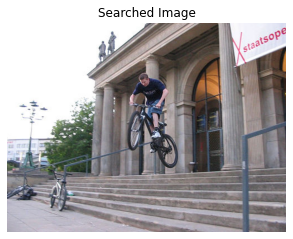

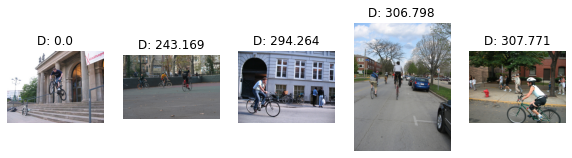

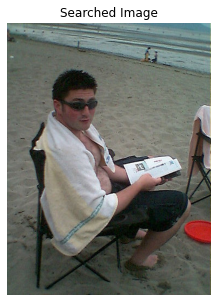

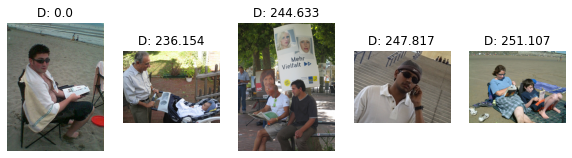

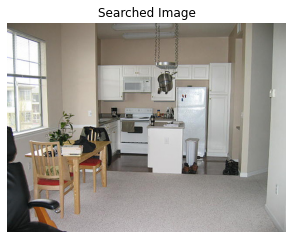

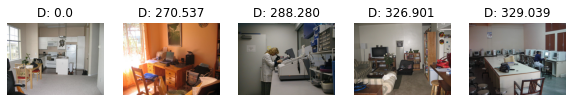

In [36]:
for x in range(len(results)):
    query_file = search_images[x]
    result_files = [red.get(y.id).decode('utf-8') for y in results[x]]
    distances = [y.distance for y in results[x]]
    show_results(query_file, result_files, distances)

## Conclusion
This notebook shows how to search for similar images. 

We have also built a [demo system](https://zilliz.com/milvus-demos) where you can perform a search on 1M+ images.